In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import sklearn.cluster as sk_cluster
import sklearn.feature_extraction.text as sk_text
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage      

%matplotlib inline
pd.set_option('display.max_colwidth', -1)

In [2]:
cleaned_data = pd.read_csv('cleaned_data.csv')
clinton_trump_texts = pd.read_table('clinton_trump_user_classes.txt', names = ['UserID', 'Class'], sep='\t')

In [3]:
clinton_trump_texts_agg = cleaned_data.groupby('UserID')['Hash'].apply(" ".join)
clinton_trump_sklearn = pd.DataFrame({'User_id':clinton_trump_texts_agg.index,'All_hashtag':clinton_trump_texts_agg.values})

In [4]:
vectorizer = sk_text.TfidfVectorizer(stop_words='english',max_features=4, min_df=1, max_df=300)
matrix = vectorizer.fit_transform(clinton_trump_sklearn.All_hashtag.values)
tfidf = matrix.toarray()

In [5]:
df = pd.DataFrame(matrix.todense(),index = clinton_trump_texts_agg.index, columns = vectorizer.get_feature_names())

In [6]:
merged_df = pd.merge(df,clinton_trump_texts, on='UserID')

## Task 1.1

### Let’s apply clustering and compare the clustering result against a known ground truth. In the file “clinton_trump_user_classes.txt”, we have the ground truth “class” membership for each user id in the data. Class 0 corresponds to Trump followers, while class 1 corresponds to Clinton followers.

### Run the k-means algorithm (K=2) and the two different variations of the agglomerative clustering algorithm (MAX-based and SSE-based).

In [7]:
### Compute the confusion matrix, precision, recall, and F-measure for (1) k-means, (2) MAX-based agglomerative clustering, and (3) SSE-based agglomerative clustering. Compare their performance and include your conclusions in your report. See sample code in lab 4.

## K-means

In [8]:
%%time
kmeans = sk_cluster.KMeans(n_clusters=2, n_init=10, max_iter=300)
kmeans_label = kmeans.fit_predict(tfidf)

CPU times: user 103 ms, sys: 11.1 ms, total: 114 ms
Wall time: 59.8 ms


In [9]:
print ('\nPrinting cluster assignment:')
print(kmeans_label)


Printing cluster assignment:
[0 0 0 ... 0 0 0]


In [10]:
print('\n')
error = kmeans.inertia_       #SSE; Sum of squared distances of samples to their closest cluster center.
print ("The total error of the clustering is: ", error)



The total error of the clustering is:  193.9585171605127


In [11]:
truth = np.array(merged_df.Class.values)
truth

array([1, 0, 0, ..., 1, 1, 1])

In [12]:
confusion = metrics.confusion_matrix(truth, kmeans.labels_, labels=[0, 1])   # first row: 0 ; second row: 1
print(confusion)

[[4515   89]
 [4216  101]]


In [13]:
metrics.precision_score(truth, kmeans.labels_, average='weighted') # weighted: the average precision of all clusters is returned


0.5241183865429376

In [14]:
metrics.recall_score(truth, kmeans.labels_, average='weighted')  # weighted: the average recall of all clusters is returned


0.5174307813025446

In [15]:
metrics.f1_score(truth, kmeans.labels_, average= 'weighted')     # weighted: the average f1 of all clusters is returned


0.3711639557229499

## Agglomerative Clustering

### MAX based

In [16]:
%%time
ag1 = sk_cluster.AgglomerativeClustering(linkage = 'complete', n_clusters = 2) 

CPU times: user 54 µs, sys: 216 µs, total: 270 µs
Wall time: 280 µs


In [17]:
ag_labels = ag1.fit_predict(tfidf)

In [18]:
print ('\nPrinting cluseter assignment:')
ag_labels


Printing cluseter assignment:


array([0, 0, 0, ..., 0, 0, 0])

In [19]:
confusion = metrics.confusion_matrix(truth, ag1.labels_, labels=[0, 1])   # first row: 0 ; second row: 1
print(confusion)

[[4516   88]
 [4218   99]]


In [20]:
metrics.precision_score(truth, ag1.labels_, average='weighted') # weighted: the average precision of all clusters is returned


0.5230370757627189

In [21]:
metrics.recall_score(truth, ag1.labels_, average='weighted')  # weighted: the average recall of all clusters is returned


0.5173186862459366

In [22]:
metrics.f1_score(truth, ag1.labels_, average= 'weighted')     # weighted: the average f1 of all clusters is returned


0.37074741921708015

### SSE based

In [23]:
ag2 = sk_cluster.AgglomerativeClustering(linkage = 'ward', n_clusters = 2)   

In [24]:
ag_labels2 = ag2.fit_predict(merged_df)

In [25]:
print ('\nPrinting cluseter assignment:')
ag_labels2 


Printing cluseter assignment:


array([1, 1, 1, ..., 0, 0, 0])

In [26]:
confusion = metrics.confusion_matrix(truth, ag2.labels_, labels=[0, 1])   # first row: 0 ; second row: 1
print(confusion)

[[2220 2384]
 [1291 3026]]


In [27]:
metrics.precision_score(truth, ag2.labels_, average='weighted') # weighted: the average precision of all clusters is returned


0.5969901995123185

In [28]:
metrics.recall_score(truth, ag2.labels_, average='weighted')  # weighted: the average recall of all clusters is returned


0.5880506669655868

In [29]:
metrics.f1_score(truth, ag2.labels_, average= 'weighted')     # weighted: the average f1 of all clusters is returned


0.583453062904208

## Task 1.2

### For k-means, look at the two centers (centroids) and print the top-30 hashtags/handles with the highest tfidf values.

In [30]:
centroids = kmeans.cluster_centers_
print ('Cluster Centroids')
print(centroids)

Cluster Centroids
[[1.26460471e-02 4.71805729e-03 4.84576546e-03 8.84475664e-05]
 [1.64408666e-02 2.13952325e-03 4.59031264e-03 9.92576476e-01]]


In [31]:
asc_order_centroids = kmeans.cluster_centers_.argsort()    # argsort() returns the indices that would sort an array.
des_order_centroids = asc_order_centroids[:,::-1] 

In [32]:
terms = vectorizer.get_feature_names()
print ("All the terms:")
print(terms, '\n')

for i in range(2):
    print ("Cluster:", i)
    for ind in des_order_centroids[i, :30]:
        print (terms[ind])
    print()  

All the terms:
['news', 'nowplaying', 'pjnet', 'quote'] 

Cluster: 0
news
pjnet
nowplaying
quote

Cluster: 1
quote
news
pjnet
nowplaying



In [33]:
asc_order_centroids

array([[3, 1, 2, 0],
       [1, 2, 0, 3]])

## Task 1.3

### Show the two respective word clouds of the two centers (centroids) by using hashtags/handles and their tfidf values. Hint: Use function fit_words() that comes with wordcloud

# 2. Clustering of Hashtags/handles

## Task 2.1

### First, you apply the k-means algorithm. Create a plot of the SSE error of the k-means algorithm as a function of the number of clusters, for k up to 20, in order to determine the optimal number of clusters.

Text(0, 0.5, 'SSE')

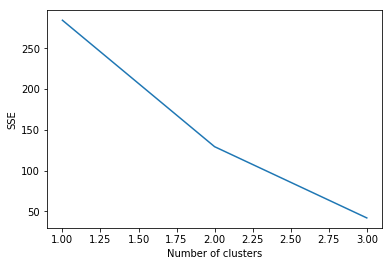

In [35]:
error = np.zeros(4)
for k in range(1,4):
    kmeans = sk_cluster.KMeans(n_clusters=k, n_init=10, max_iter=500)
    kmeans.fit_predict(tfidf.transpose())
    error[k] = kmeans.inertia_

plt.plot(range(1, 4), error[1:])
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

## Task 2.2

### Run the k-means algorithm for the optimal number of clusters you identified in the last task. Print some hashtags/handles in each cluster. From the hashtags/handles in each cluster, try to deduce what is the topic it concerns. Include your conclusions in your report.

In [36]:
kmeans = sk_cluster.KMeans(n_clusters=6, n_init=10, max_iter=300)
kmeans_label = kmeans.fit_predict(tfidf)

In [37]:
print ('\nPrinting cluster assignment:')
print(kmeans_label)


Printing cluster assignment:
[0 0 0 ... 0 0 0]


In [38]:
print('\n')
error = kmeans.inertia_       #SSE; Sum of squared distances of samples to their closest cluster center.
print ("The total error of the clustering is: ", error)



The total error of the clustering is:  1.551199290832352


In [39]:
truth = np.array(merged_df.Class.values)
truth

array([1, 0, 0, ..., 1, 1, 1])

In [40]:
confusion = metrics.confusion_matrix(truth, kmeans.labels_, labels=[0, 1])   # first row: 0 ; second row: 1
print(metrics.precision_score(truth, kmeans.labels_, average='weighted')) # weighted: the average precision of all clusters is returned
printmetrics.recall_score(truth, ag2.labels_, average='weighted'))  # weighted: the average recall of all clusters is returned
metrics.f1_score(truth, ag2.labels_, average= 'weighted')     # weighted: the average f1 of all clusters is returned

print(confusion)

[[4412   54]
 [4126   55]]


In [41]:
metrics.precision_score(truth, kmeans.labels_, average='weighted') # weighted: the average precision of all clusters is returned


0.5108635299938901

In [42]:
metrics.recall_score(truth, ag2.labels_, average='weighted')  # weighted: the average recall of all clusters is returned


0.5880506669655868

In [43]:
metrics.f1_score(truth, ag2.labels_, average= 'weighted')     # weighted: the average f1 of all clusters is returned


0.583453062904208